In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [1]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session, sessionmaker
from sqlalchemy import create_engine, inspect, Table, func
from sqlalchemy.engine import reflection

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")


In [5]:
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [6]:
# reflect an existing database into a new model
Base = automap_base()


# reflect the tables
Base.prepare(engine, reflect=True)


/var/folders/m0/xq3r3nm57yq55crv150tzx9h0000gn/T/ipykernel_3433/430117948.py:6: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [9]:
# View all of the classes that automap found

Base.classes.keys()

if Base.classes:
    for name in Base.classes.keys():
        print(name)
else:
    print("No classes found.")



measurement
station


In [10]:
# Save references to each table

Measurement = Base.classes.measurement
Station = Base.classes.station

In [11]:
# Check if references saved in each table

for table_name in inspector.get_table_names():
    print(f"Table: {table_name}")
    

Table: measurement
Table: station


In [12]:
# Create our session (link) from Python to the DB

session = Session(bind=engine)

session

# Create a session

#session


In [13]:
Measurement_mapper = Measurement.__mapper__
print(session.bind)

Engine(sqlite:///Resources/hawaii.sqlite)


# Exploratory Precipitation Analysis

In [22]:
# Find the most recent date in the data set.
most_recent_date_str = session.query(func.max(Measurement.date)).scalar()
print(most_recent_date_str, type(most_recent_date_str))

2017-08-23 <class 'str'>


In [23]:
most_recent_date = dt.date.fromisoformat(most_recent_date_str)

print(most_recent_date, type(most_recent_date))

2017-08-23 <class 'datetime.date'>


In [25]:
one_year_from_recent_date = most_recent_date - dt.timedelta(days=365)
   
# Perform a query to retrieve the data and precipitation scores
precipitation_scores = session.query(Measurement.date, Measurement.prcp)\
   .filter(Measurement.date.between(one_year_from_recent_date, most_recent_date))\
   .all()
len(precipitation_scores)

2230

Text(0, 0.5, 'Precipitation (Inches)')

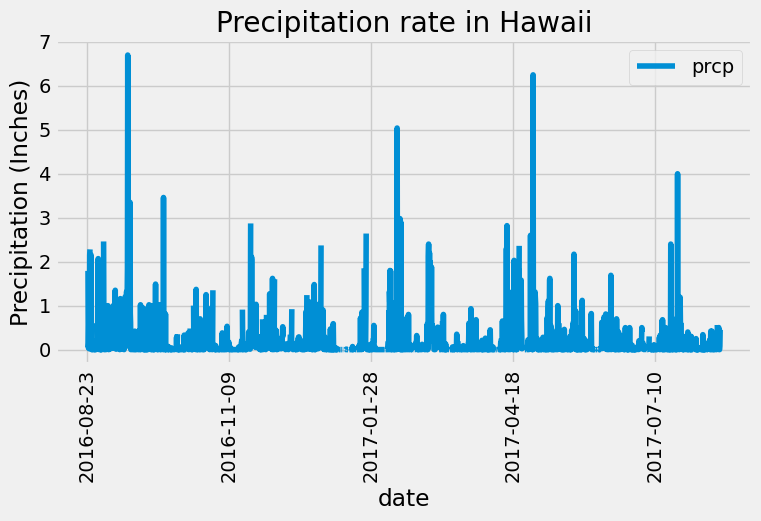

In [29]:

# Design a query to retrieve the last 12 months of precipitation data and plot the results. 

# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.

#one_year_from_recent_date = most_recent_date - dt.timedelta(days=365)
   
# Perform a query to retrieve the data and precipitation scores
#precipitation_scores = session.query(Measurement.date, Measurement.prcp)\
   #.filter(Measurement.date.between(one_year_from_recent_date, most_recent_date))\
   #.all()
#precipitation_scores

# Save the query results as a Pandas DataFrame and set the index to the date column

# precipitation_scores_DF = pd.read_sql(session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= one_year_from_recent_date).statement, session.bind)

precipitation_scores_DF = pd.DataFrame(precipitation_scores)
precipitation_scores_DF.set_index('date', inplace=True)
precipitation_scores_DF = precipitation_scores_DF.sort_index()


# Sort the dataframe by date

precipitation_scores_DF.sort_values(by='date')

# Use Pandas Plotting with Matplotlib to plot the data

precipitation_scores_DF.plot(figsize=(8,4))
plt.xticks(rotation='vertical')
plt.title('Precipitation rate in Hawaii')
plt.ylabel('Precipitation (Inches)')




In [32]:
precipitation_scores_DF

,prcp
date,
2016-08-23,0.00
2016-08-23,NaN
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15
...,...
2017-08-22,0.00
2017-08-23,0.00
2017-08-23,0.00


In [33]:
# Use Pandas to calculate the summary statistics for the precipitation data

precipitation_avg = precipitation_scores_DF['prcp'].mean().round(2)
precipitation_min = precipitation_scores_DF['prcp'].min()
precipitation_max = precipitation_scores_DF['prcp'].max()
precipitation_max

summary_statistics = pd.DataFrame({
    "Average Precipitation": precipitation_avg,
    "Minimum Precipitation": precipitation_min,
    "Maximum Precipitation": precipitation_max
}, index=[0])

summary_statistics


,Average Precipitation,Minimum Precipitation,Maximum Precipitation
0,0.18,0.0,6.7


# Exploratory Station Analysis

In [34]:
station_columns = Station.__table__.columns.keys()
print(station_columns)

['id', 'station', 'name', 'latitude', 'longitude', 'elevation']


In [35]:
# Design a query to calculate the total number stations in the dataset

stations_total = session.query(func.count(Station.station)).scalar()

# print the result
print(f"Total number of stations: {stations_total}")


Total number of stations: 9


In [37]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)

active_stations = session.query(Station.station, func.count(Measurement.station)).\
    filter(Station.station == Measurement.station).\
    group_by(Station.station).\
    order_by(func.count(Measurement.station).desc()).all()

# List the stations and the counts in descending order.

for active_station, count in active_stations:
    print(f"{active_station}: {count}")


USC00519281: 2772
USC00519397: 2724
USC00513117: 2709
USC00519523: 2669
USC00516128: 2612
USC00514830: 2202
USC00511918: 1979
USC00517948: 1372
USC00518838: 511


In [53]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

lowest_temp = session.query(func.min(Measurement.tobs)).\
    filter(Measurement.station == active_station).scalar()

highest_temp = session.query(func.max(Measurement.tobs)).\
    filter(Measurement.station == active_station).scalar()

average_temp = session.query(func.avg(Measurement.tobs)).\
    filter(Measurement.station == active_station).scalar()

average_temp = round(average_temp, 2)

temp_summary = pd.DataFrame({
    "Lowest Temperture": lowest_temp,
    "Highest Temperture": highest_temp,
    "average_temp": average_temp
},index=[0])


temp_summary


,Lowest Temperture,Highest Temperture,average_temp
0,58.0,83.0,72.72


In [65]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_active_station = session.query(Measurement.station, func.count(Measurement.station)).\
     group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).first()
most_active_station_id = most_active_station[0]


temperature_last_12_months = session.query(Measurement.tobs).\
    filter(Measurement.station == most_active_station_id).\
    filter(Measurement.date.between(one_year_from_recent_date, most_recent_date)).all()


temperature_last_12_months_df = pd.DataFrame(temperature_last_12_months, columns=['tobs'])


temperature_last_12_months_df

,tobs
0,77.0
1,77.0
2,80.0
3,80.0
4,75.0
...,...
347,77.0
348,77.0
349,76.0
350,76.0


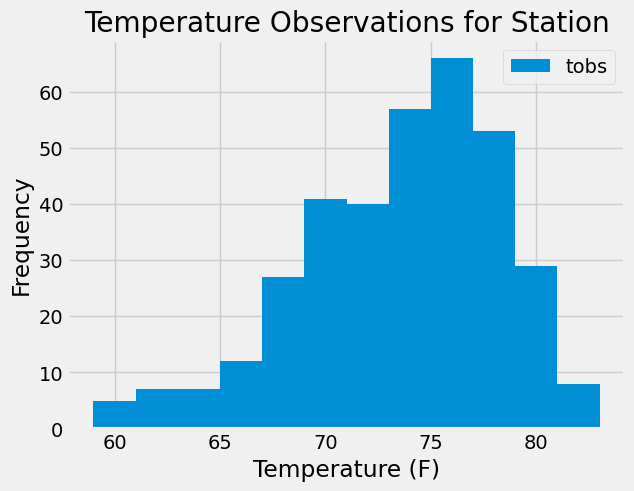

In [67]:
# Plot the results as a histogram
temperature_last_12_months_df.plot.hist(bins=12)

plt.title(f"Temperature Observations for Station")
plt.xlabel("Temperature (F)")
plt.ylabel("Frequency")

plt.show()

# Close session

In [68]:
# Close Session
session.close()

Part 2: FLASK

In [74]:
from flask import Flask, jsonify

app = Flask(__name__)


@app.route("/")
def home():
    return (
        f"Available Routes:<br/>"
        f"/api/v1.0/precipitation<br/>"
        f"/api/v1.0/stations<br/>"
        f"/api/v1.0/tobs<br/>"
        f"/api/v1.0/start_date<br/>"
        f"/api/v1.0/start_date/end_date"
    )

@app.route("/api/v1.0/precipitation")
def precipitation():
    
    return jsonify(precipitation_scores_DF)

@app.route("/api/v1.0/stations")
def stations():
    results = session.query(Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation).all()
    stations_list = []
    for station, name, latitude, longitude, elevation in results:
        station_dict = {}
        station_dict["station"] = station
        station_dict["name"] = name
        station_dict["latitude"] = latitude
        station_dict["longitude"] = longitude
        station_dict["elevation"] = elevation
        stations_list.append(station_dict)
    
    return jsonify(stations_list)

@app.route("/api/v1.0/tobs")
def tobs():    
    
    active_station = session.query(Measurement.station).\
        group_by(Measurement.station).\
        order_by(desc(func.count(Measurement.station))).\
        first()[0]
    results = session.query(Measurement.date, Measurement.tobs).\
        filter(Measurement.station == active_station).\
        filter(Measurement.date >= one_year_from_recent_date).\
        order_by(Measurement.date).all()
    temperatures_list = [t[1] for t in results]
    return jsonify(temperatures_list)
